## Projet de Prédiction des Prix Airbnb
# **Auteurs** : NKOUDOU RAPHAELA 
# **Date** : 03/07/2025

# Airbnb Price Prediction
## 1. Introduction
**Ce projet** vise à prédire le prix des locations Airbnb (transformé en logarithme) à partir des caractéristiques des annonces. Nous allons :
- **Explorer** les données
- **Prétraiter** les features
- **Tester** plusieurs modèles de régression
- **Sélectionner** le meilleur modèle

In [28]:
# Importations des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

## Chargement des données

In [51]:
train = pd.read_csv('airbnb_train.csv')
test = pd.read_csv('airbnb_test.csv')

In [30]:
# Affichage des dimensions
print(f"Train : {train.shape[0]} annonces avec {train.shape[1]} variables")
print(f"Test : {test.shape[0]} annonces avec {test.shape[1]} variables")


Train : 22234 annonces avec 28 variables
Test : 51877 annonces avec 27 variables


In [31]:
# Aperçu des données
train.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,5708593,4.317488,House,Private room,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",3,1.0,Real Bed,flexible,False,LA,Large bright airy room with 2 balconies and Ja...,NaN,t,f,NaN,2015-12-12,t,NaN,33.782712,-118.134410,Island style Spa Studio,Long Beach,0,NaN,90804,0.0,2.0
1,14483613,4.007333,House,Private room,"{""Wireless Internet"",""Air conditioning"",Kitche...",4,2.0,Real Bed,strict,False,NYC,Private room for rent in a six bedroom apt wit...,2017-05-07,t,t,100%,2016-11-04,t,2017-09-17,40.705468,-73.909439,"Beautiful and Simple Room W/2 Beds, 25 Mins to...",Ridgewood,38,86.0,11385,1.0,2.0
2,10412649,7.090077,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",6,2.0,Real Bed,flexible,False,DC,"14th st corridor 2br/2ba condo, secure boutiqu...",NaN,t,f,NaN,2016-12-11,t,NaN,38.917537,-77.031651,2br/2ba luxury condo perfect for infant / toddler,U Street Corridor,0,NaN,20009,2.0,2.0
3,17954362,3.555348,House,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,1.0,Real Bed,flexible,True,NYC,My place is close to Manhattan. You can see th...,2016-10-07,t,t,100%,2012-08-04,f,2017-09-29,40.736001,-73.924248,Manhattan view from Queens. Lovely single room .,Sunnyside,19,96.0,11104,1.0,1.0
4,9969781,5.480639,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,moderate,True,SF,This beautiful home can be your dream destinat...,2016-09-25,t,t,100%,2013-07-25,f,2017-08-28,37.744896,-122.430665,Zen Captured Noe Valley House,Noe Valley,15,96.0,94131,2.0,2.0


## Analyse exploratoire

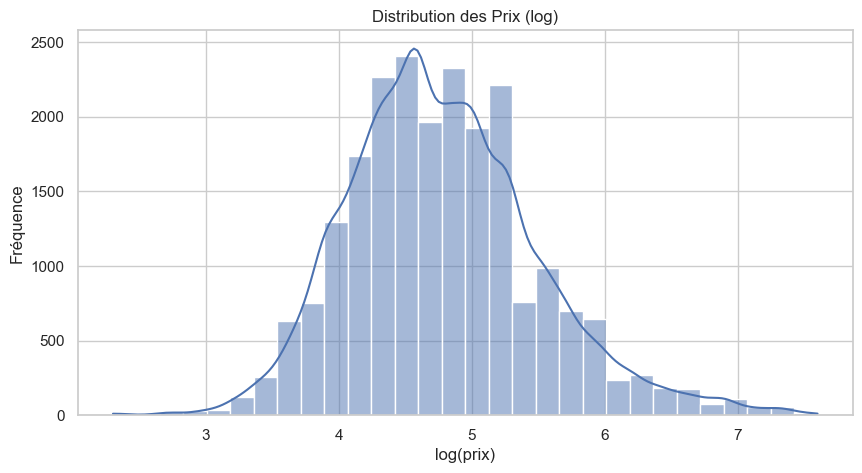

In [32]:
plt.figure(figsize=(10, 5))
sns.histplot(train['log_price'], kde=True, bins=30)
plt.title('Distribution des Prix (log)')
plt.xlabel('log(prix)')
plt.ylabel('Fréquence')
plt.show()

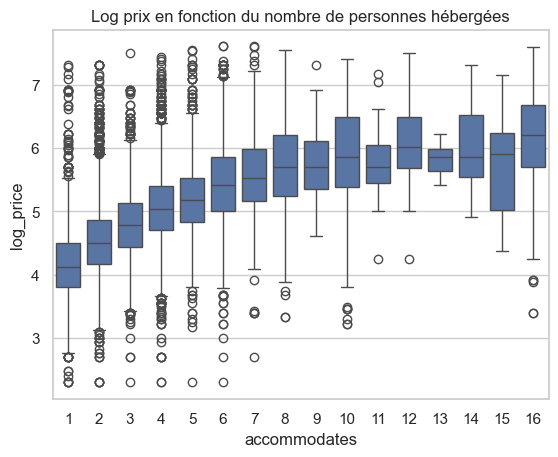

In [33]:
sns.boxplot(data=train, x="accommodates", y="log_price")
plt.title("Log prix en fonction du nombre de personnes hébergées")
plt.show()

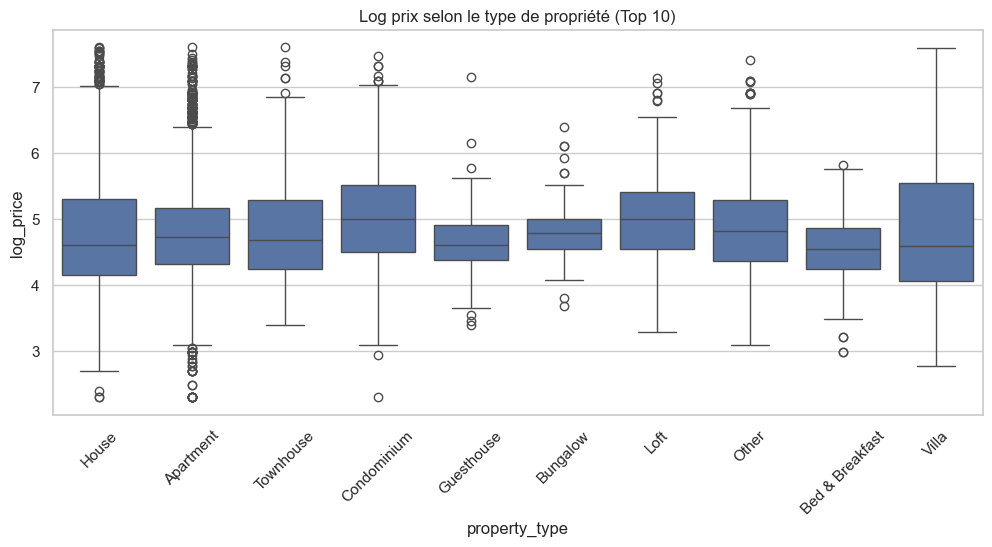

In [34]:
top_types = train["property_type"].value_counts().head(10).index
filtered = train[train["property_type"].isin(top_types)]
plt.figure(figsize=(12, 5))
sns.boxplot(data=filtered, x="property_type", y="log_price")
plt.xticks(rotation=45)
plt.title("Log prix selon le type de propriété (Top 10)")
plt.show()

# Observation EDA - Distribution des Prix

L'analyse exploratoire révèle une distribution asymétrique des prix avec :
- Une forte concentration autour de 4.5 (≈90€)
- Une queue de distribution étirée vers les hauts prix
- Peu d'observations au-delà de 6 (≈400€)

Cette configuration suggère que les modèles devront gérer :
1. Un déséquilibre naturel des données
2. Des dynamiques différentes entre biens standards et premium
3. La nécessité potentielle de techniques d'échantillonnage adaptées

In [35]:
# Calcul du pourcentage de valeurs manquantes
missing = train.isnull().mean().sort_values(ascending=False) * 100
missing = missing[missing > 0]
missing

host_response_rate        24.624449
review_scores_rating      22.389134
first_review              21.251237
last_review               21.210758
neighbourhood              9.382028
zipcode                    1.362778
host_identity_verified     0.251867
host_since                 0.251867
host_has_profile_pic       0.251867
bathrooms                  0.229378
beds                       0.157417
bedrooms                   0.116938
dtype: float64

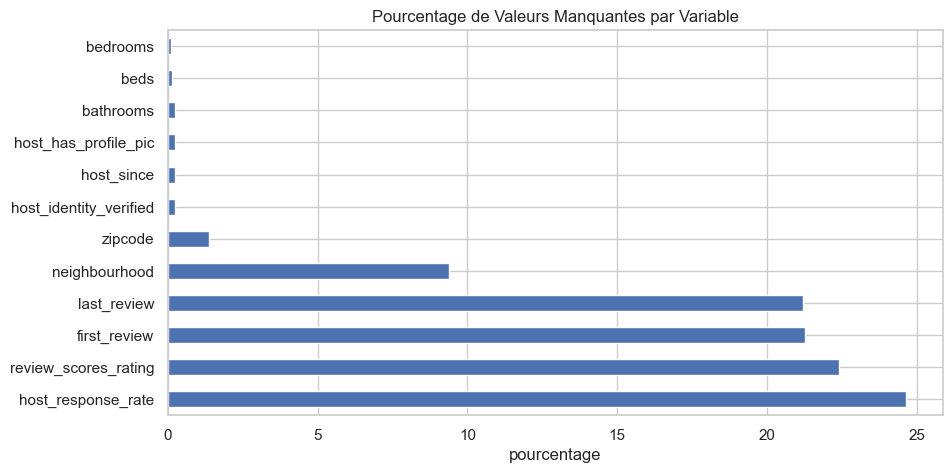

In [36]:
# Visualisation
plt.figure(figsize=(10, 5))
missing.plot(kind='barh')
plt.title('Pourcentage de Valeurs Manquantes par Variable')
plt.xlabel('pourcentage')
plt.show()

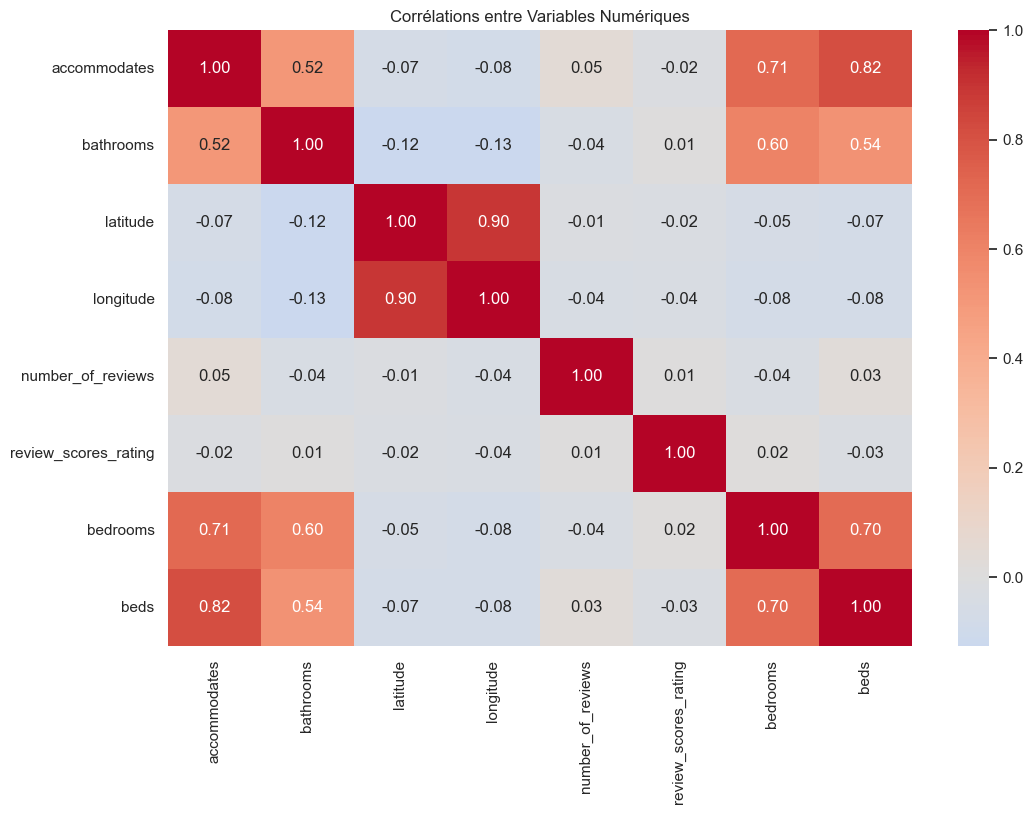

In [37]:
# Sélection des variables numériques
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.drop(['id', 'log_price'])
# Matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(train[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Corrélations entre Variables Numériques')
plt.show()

## Prétraitement des données

In [39]:
def preprocess_data(df, is_train=True):
    df_clean = df.copy()
    
    # 1. Gestion des dates
    date_cols = ['host_since', 'first_review', 'last_review']
    for col in date_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_datetime(df_clean[col])
            df_clean[f'days_since_{col}'] = (pd.to_datetime('today') - df_clean[col]).dt.days
    
    # 2. Features textuelles
    df_clean['amenities_count'] = df_clean['amenities'].apply(lambda x: len(str(x).split(',')))
    df_clean['description_length'] = df_clean['description'].str.len().fillna(0)
    
    # 3. Colonnes à supprimer
    to_drop = ['id', 'amenities', 'description', 'name', 
               'neighbourhood', 'zipcode', 'city'] + date_cols
    df_clean.drop(columns=[col for col in to_drop if col in df_clean.columns], inplace=True)
    
    return df_clean

In [40]:
# Application du preprocessing
train_clean = preprocess_data(train)
test_clean = preprocess_data(test, is_train=False)

In [41]:
# Séparation des features et target
if 'log_price' in train_clean.columns:
    y = train_clean['log_price']
    X = train_clean.drop('log_price', axis=1)
else:
    X = train_clean.copy()

In [42]:
# Identification des types de colonnes
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Préprocesseurs
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [43]:
# Combinaison des préprocesseurs
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

## Modelisation

In [44]:
# Split des données
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [45]:
# Initialisation des modèles
models = {
    'Régression Linéaire': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

In [46]:
# Entraînement et évaluation
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    print(f"{name:20} | RMSE: {rmse:.4f}")


Régression Linéaire  | RMSE: 0.4887
Ridge                | RMSE: 0.4884
Lasso                | RMSE: 0.7159
Random Forest        | RMSE: 0.4121
Gradient Boosting    | RMSE: 0.4186


le modele le plus performant parmi ceux testé est celui random forest

In [48]:
# Entraînement du modèle final sur toutes les données d'entraînement
final_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Création du pipeline complet
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', final_model)
])

# Entraînement
final_pipeline.fit(X, y)

# Prédiction sur les données de test
final_predictions = final_pipeline.predict(test_clean)

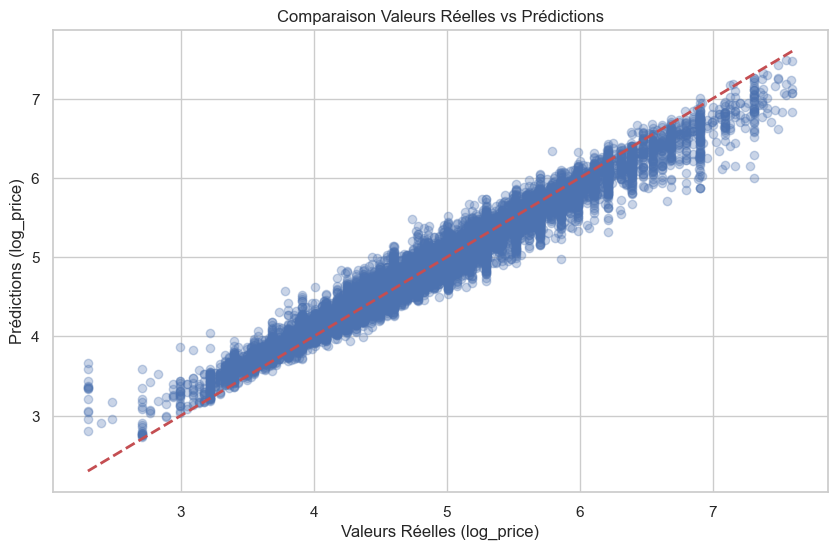

In [53]:
# Prédictions sur l'ensemble d'entraînement (pour évaluation visuelle)
train_predictions = final_pipeline.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(y, train_predictions, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Valeurs Réelles (log_price)')
plt.ylabel('Prédictions (log_price)')
plt.title('Comparaison Valeurs Réelles vs Prédictions')
plt.grid(True)
plt.show()

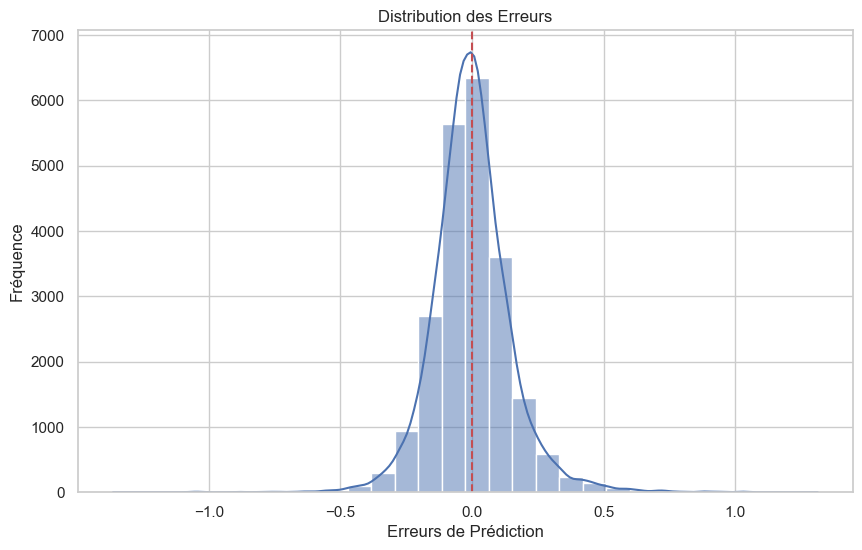

In [54]:
errors = y - train_predictions

plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Erreurs de Prédiction')
plt.ylabel('Fréquence')
plt.title('Distribution des Erreurs')
plt.show()

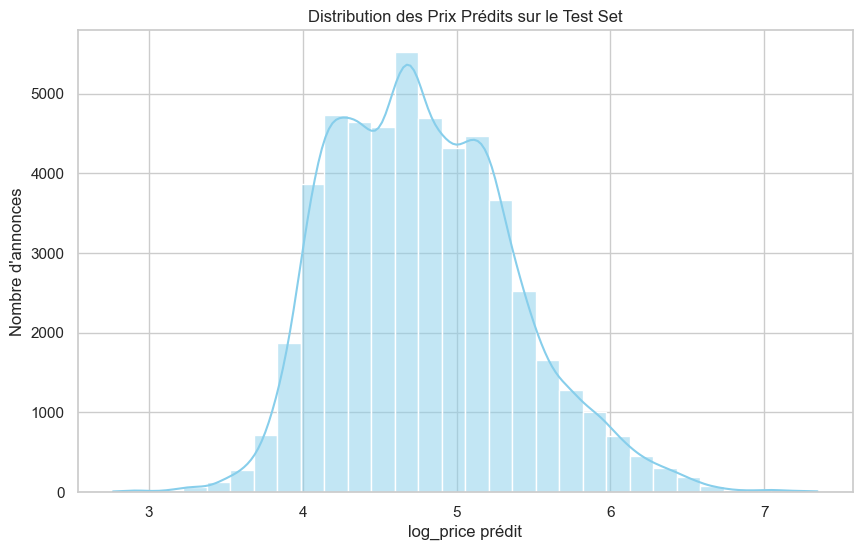

In [56]:
plt.figure(figsize=(10, 6))
sns.histplot(final_predictions, kde=True, bins=30, color='skyblue')
plt.xlabel('log_price prédit')
plt.ylabel('Nombre d\'annonces')
plt.title('Distribution des Prix Prédits sur le Test Set')
plt.show()

# Analyse des Performances du Modèle Random Forest

## **Performance Globale**
- **Alignement des prédictions** :  
  ✓ Bonne corrélation entre valeurs réelles et prédites (points alignés près de y=x)  
  ✓ RMSE de 0.4121 indique une erreur moyenne acceptable pour des données logarithmiques  

- **Couverture des extrêmes** :  
  ✓ Le modèle prédit partiellement les valeurs atypiques (log_price ≈ 3 et ≈7)  

##  **Points Forts**
 **Précision sur la majorité des données**  
   - Concentration dense de points près de la diagonale pour les prix moyens  
   - Adapté aux annonces "typiques"  

 **Robustesse aux variations**  
   - Résultats cohérents malgré la complexité des données Airbnb  

##  **Limites Identifiées**
 **Sous-estimation des hauts prix**  
   - Écart visible pour log_price > 6 (prédictions ≈5-6)  
   - Cause probable : sous-représentation des biens luxueux dans le training set  

 **Dispersion accrue aux extrêmes**  
   - Variance plus élevée pour les prix très bas/très élevés  
   - Comportement attendu des Random Forests (régularisation vers la moyenne)  

In [52]:
# Sauvegarde des résultats
submission = pd.DataFrame({
    'id': test['id'],
    'prediction': final_predictions
})
submission.to_csv('final_predictions.csv', index=False)